This notebook intend to keep track of the workflow developed to integrate Sentinel-2 MSI data to the CIDCO Lidar-Bathy project.
Specifically the goal is to add multispectral bottom reflectance data to the geomorphometric algorithm to perform submerged aquatic vegetation (SAV) detection and mapping.

In [1]:
import shutil
import subprocess
%matplotlib inline

import urllib
import plotly.graph_objects as go
import plotly.express as px
import os
from osgeo import ogr, gdal
import sys
from zipfile import ZipFile

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import pandas as pd
import geopandas as gpd
import json
import geojson
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import xarray as xr

from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from functools import partial

from shapely.geometry import Polygon, shape, box

import requests

UserHome = os.path.expanduser("~")
sys.path.append(os.path.join(UserHome, "acolite"))
import acolite as ac

api = SentinelAPI(None, None, 'https://apihub.copernicus.eu/apihub')

Loading the bathymetric surface and converting it to a geometry and then to geodataframe

In [2]:
Surface = pd.read_csv("~/LidarBathy/surfaces/Manicouagan_20181015_NAD83(SCRS)_MTU19N_ZC_MareeGPS_CUBE_25cm.txt", sep=" ")
Surface['Depth'] = -Surface.Depth

In [3]:
GeometrySurface = gpd.points_from_xy(Surface['Easting'], Surface['Northing'], crs="EPSG:2960")

In [4]:
gdf = gpd.GeoDataFrame(Surface, geometry=GeometrySurface)

In [5]:
min(gdf.Depth), max(gdf.Depth)

(-45.419, -0.683)

Rasterize point data with the 'geocube' library, this method rely on the scipy.interpolate.griddata to interpolate point to aa grid.
I would prefer to use gdal_grid, but I have trouble with the GDAL API

In [6]:
geo_grid = make_geocube(
    vector_data=gdf,
    measurements=['Depth'],
    resolution=(10, 10),
    rasterize_function=partial(rasterize_points_griddata, method="nearest"),
)

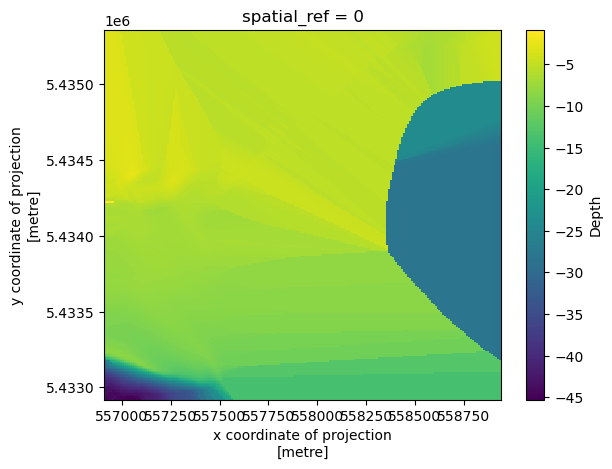

In [7]:
geo_grid.Depth.where(geo_grid.Depth!=geo_grid.Depth.rio.nodata).plot()

In [8]:
bbox = box(*gdf.total_bounds)

Define an area of interest, here manicouagan peninsula.

In [9]:
bbox_json = gpd.GeoSeries([bbox]).set_crs("EPSG:2960").to_crs('EPSG:4326').to_json()

In [10]:
bbox_json = json.loads(bbox_json)

In [11]:
bbox_json

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-68.19350107437607, 49.04642664875187],
      [-68.19314797862883, 49.068245385816276],
      [-68.22078338837856, 49.06843527123537],
      [-68.22112439326195, 49.046616389105246],
      [-68.19350107437607, 49.04642664875187]]]},
   'bbox': [-68.22112439326195,
    49.04642664875187,
    -68.19314797862883,
    49.06843527123537]}],
 'bbox': [-68.22112439326195,
  49.04642664875187,
  -68.19314797862883,
  49.06843527123537]}

In [12]:
bbox_wkt = geojson_to_wkt(bbox_json)

In [13]:
Date = ('20180801', date(2018, 8, 31))
print(Date)

('20180801', datetime.date(2018, 8, 31))


We wrap up the query to the OpenSearch [Solr](https://scihub.copernicus.eu/userguide/5APIsAndBatchScripting#Open_Search)

In [14]:
Products = api.query(bbox_wkt,
                     date=Date,
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 5))

In [15]:
GeoData = api.to_geodataframe(Products)

In [16]:
GeoData = GeoData.to_crs('EPSG:2960')

In [17]:
quicklook = GeoData[GeoData['processinglevel'] == 'Level-1C']['link_icon'][0]
quicklook

"https://apihub.copernicus.eu/apihub/odata/v1/Products('980e3f60-76cd-499f-b766-08c15fbe5025')/Products('Quicklook')/$value"

In [18]:
r = requests.get(GeoData[GeoData['processinglevel'] == 'Level-1C']['link_icon'][0], allow_redirects=True)

In [19]:
open('Quicklook.jpg', 'wb').write(r.content)

14175

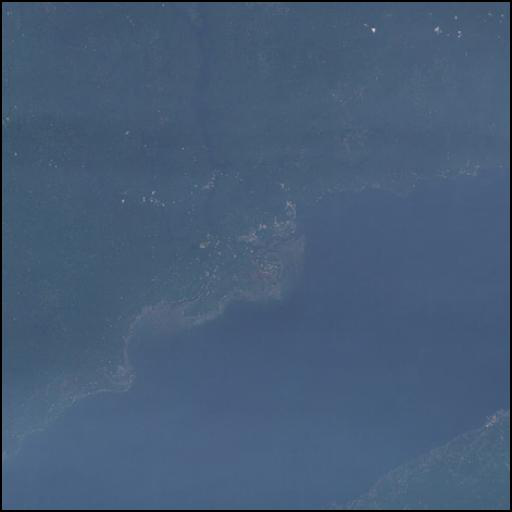

In [20]:
img = PIL.Image.open('Quicklook.jpg')
display(img)

In [39]:
# create a file-like object from the url
f = urllib.request.urlopen(quicklook)

# read the image file in a numpy array
a = plt.imread(f)
plt.imshow(a)
plt.show()

HTTPError: HTTP Error 401: 

In [21]:
df = geo_grid.to_dataframe().reset_index()

In [22]:
df

,y,x,Depth,spatial_ref
0,5432925.0,556915.0,-44.275,0
1,5432925.0,556925.0,-44.372,0
2,5432925.0,556935.0,-44.372,0
3,5432925.0,556945.0,-44.372,0
4,5432925.0,556955.0,-43.473,0
...,...,...,...,...
49527,5435355.0,558895.0,-4.339,0
49528,5435355.0,558905.0,-4.391,0
49529,5435355.0,558915.0,-4.345,0
49530,5435355.0,558925.0,-4.228,0


In [23]:

gdf = gpd.GeoDataFrame(
    df.Depth, geometry=gpd.points_from_xy(df.x, df.y))

<Axes: >

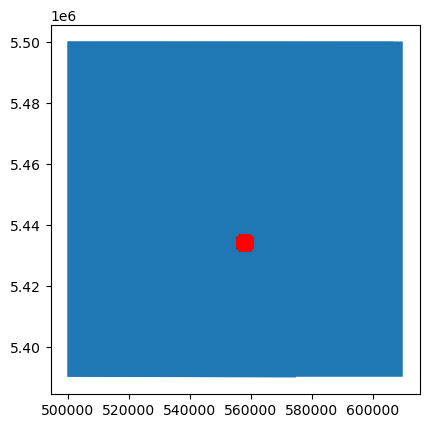

In [24]:
f, ax = plt.subplots(1)
GeoData.plot(ax = ax)
gdf.plot(ax = ax, color = 'red')

Create directory to store L1c images

In [25]:
InputPath = os.path.join(UserHome,"sensor", "MSI", "L1C")

try:
    os.makedirs(InputPath)
except FileExistsError:
    print("FileExistsError")
    pass

FileExistsError


Download the image

In [26]:
ID = GeoData[GeoData['processinglevel'] == 'Level-1C']['uuid'][0]

In [27]:
Result = api.download_all(
    products = [ID],
    directory_path = InputPath,
    max_attempts = 10,
    checksum = True,
    n_concurrent_dl = api.concurrent_dl_limit,
    lta_retry_delay = 1800,
    fail_fast = False,
    nodefilter = None
)

MD5 checksumming:   0%|          | 0.00/646M [00:00<?, ?B/s]

Now create a temporary folder to extract the .safe archive and perform the atmospheric correction with ACOLITE.

In [28]:
TmpPath = os.path.join(UserHome, "tmp")

try:
    os.makedirs(TmpPath)
except FileExistsError:
    print("FileExistsError")
    pass

FileExistsError


In [29]:
shutil.unpack_archive(Result[0][ID]["path"], TmpPath)

In [40]:
InFile = os.path.join(os.getcwd(),TmpPath,Result[0][ID]["title"]+".SAFE")

Save the bathy surface bbox as geojson to use it as polygon_limit in ACOLITE. Will only perform atmospheric compensation for data inside this bbox.

In [44]:
TmpGeojson = os.path.join(os.getcwd(),TmpPath,"polygon_limit.geojson")
TmpGeojson

'/home/raphael/tmp/polygon_limit.geojson'

In [45]:
with open(TmpGeojson, 'w') as outfile:
    geojson.dump(bbox_json, outfile)

In [42]:
Output = os.path.join(os.getcwd(),TmpPath)

In [46]:
Settings = {"inputfile":InFile,
            "output":Output,
            "polygon":TmpGeojson,
            "polygon_limit":True,
            "s2_target_res":10,
            "output_xy":True,
            "reproject_before_ac":True,
            "output_projection_epsg":2960,
            "dsf_residual_glint_correction":True}
Settings

{'inputfile': '/home/raphael/tmp/S2A_MSIL1C_20180813T153601_N0206_R111_T19UEQ_20180813T193052.SAFE',
 'output': '/home/raphael/tmp',
 'polygon': '/home/raphael/tmp/polygon_limit.geojson',
 'polygon_limit': True,
 's2_target_res': 10,
 'output_xy': True,
 'reproject_before_ac': True,
 'output_projection_epsg': 2960,
 'dsf_residual_glint_correction': True}

In [47]:
AcoliteResults = ac.acolite.acolite_run(settings=Settings)

Running ACOLITE processing - Generic GitHub Clone c2023-02-16T16:29:09
Python - linux - 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
Platform - Linux 5.15.0-60-generic - x86_64 - #66-Ubuntu SMP Fri Jan 20 14:29:49 UTC 2023
Run ID - 20230309_145119
Identified /home/raphael/tmp/S2A_MSIL1C_20180813T153601_N0206_R111_T19UEQ_20180813T193052.SAFE as Sentinel-2 type
Starting conversion of 1 scenes
Starting conversion of /home/raphael/tmp/S2A_MSIL1C_20180813T153601_N0206_R111_T19UEQ_20180813T193052.SAFE
Importing metadata from L1C_T19UEQ_A016410_20180813T153556
Using limit from polygon envelope: [49.04642664875187, -68.22112439326195, 49.06843527123537, -68.19314797862883]
clip mask (247, 209)
Reading per pixel geometry
Computing band average per detector geometry
Detector 1


/home/raphael/acolite/acolite/sentinel2/l1_convert.py:415: RuntimeWarning: Mean of empty slice
  ave_vza = np.nanmean(ave_vza, axis=2)
/home/raphael/acolite/acolite/sentinel2/l1_convert.py:416: RuntimeWarning: Mean of empty slice
  ave_vaa = np.nanmean(ave_vaa, axis=2)


Detector 2
Detector 3
Detector 4
Detector 5
Detector 6
Detector 7
Wrote raa (247, 209)
Wrote vza (247, 209)
Wrote sza (247, 209)
Writing geolocation lon/lat
(247, 209)
Wrote lon
(247, 209)
Wrote lat
Converting bands
Converting bands: Wrote rhot_443 ((247, 209))
Converting bands: Wrote rhot_492 ((247, 209))
Converting bands: Wrote rhot_560 ((247, 209))
Converting bands: Wrote rhot_665 ((247, 209))
Converting bands: Wrote rhot_704 ((247, 209))
Converting bands: Wrote rhot_740 ((247, 209))
Converting bands: Wrote rhot_783 ((247, 209))
Converting bands: Wrote rhot_833 ((247, 209))
Converting bands: Wrote rhot_865 ((247, 209))
Converting bands: Wrote rhot_945 ((247, 209))
Converting bands: Wrote rhot_1373 ((247, 209))
Converting bands: Wrote rhot_1614 ((247, 209))
Converting bands: Wrote rhot_2202 ((247, 209))
Conversion took 6.3 seconds
Created /home/raphael/tmp/S2A_MSI_2018_08_13_15_35_56_T19UEQ_L1R.nc
Wrote /home/raphael/tmp/S2A_MSI_2018_08_13_15_35_56_T19UEQ_L1R_rgb_rhot.png
Running aco

In [48]:
AcoliteResults[0]["l2r"][0]

'/home/raphael/tmp/S2A_MSI_2018_08_13_15_35_56_T19UEQ_L2R.nc'

In [50]:
L2 = xr.open_dataset(AcoliteResults[0]["l2r"][0])

In [51]:
RGBVar = [
    "rhos_492",
    "rhos_560",
    "rhos_665"
]

L2RGB = L2[RGBVar].to_array()

In [52]:
L2RGB

<xarray.DataArray (variable: 3, y: 247, x: 209)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.05228172, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.04282388, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.0498719 , ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.05037557, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.02954701, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.02723213, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * x         (x) float64 5.569e+05 5.569e+05 5.569e+05 ... 5.59e+05 5.59e+05
  * y         (y) float64 5.435e+06 5.435e+06 5.435e+06 ... 5.433e+06 5.433e+06
  * variable  (variable) object 'rhos_492' 'rhos_560' 'rhos_665'
Attributes: (12/343)
    generated_by:                              ACOLITE
    generated_on:                              2023-03-09 14:51:24 UTC
    contact:                                   Quinten Vanhellemont
    product_type:                              NetCDF
    metadata_profile:                          beam
    metadata_version:                          0.5
    ...                                        ...
    ac_bands:                                  1,2,3,4,5,6,7,8,8A
    ac_nbands_fit:                             2
    ac_band1_idx:                              4
    ac_band1:                                  5
    ac_band2_idx:                              3
    ac_band2:                                  4

Plotting the entire image interactively in RGB (multichannel) or even  is extremely slow. Computation time could be improved by masking data based on depth ([GEBCO](https://www.gebco.net/) ?)

In [ ]:
fig = go.Figure(go.Image(z=L2RGB))
fig.show()

In [55]:
px.imshow(L2["rhos_560"], color_continuous_scale='blackbody', aspect='equal')